<a href="https://colab.research.google.com/github/Ashonet/CSCU9M5/blob/main/CSCU9M5_Assignment_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First rows:
   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain area
0  2  4   sep  sun  50.4  46.2  706.6  0.4  12.2  78   6.3   0.0    T
1  6  5   jun  sat  53.4  71.0  233.8  0.4  10.6  90   2.7   0.0    T
2  2  4   sep  mon  63.5  70.8  665.3  0.8  22.6  38   3.6   0.0    F
3  6  5   aug  fri  63.5  70.8  665.3  0.8  17.0  72   6.7   0.0    F
4  4  6   feb  sat  68.2  21.5   87.2  0.8  15.4  40   2.7   0.0    F

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       515 non-null    int64  
 1   Y       515 non-null    int64  
 2   month   515 non-null    object 
 3   day     515 non-null    object 
 4   FFMC    515 non-null    float64
 5   DMC     515 non-null    float64
 6   DC      515 non-null    float64
 7   ISI     515 non-null    float64
 8   temp    515 non-null    float64
 9   RH      515 non-null    int64  
 10  wind   

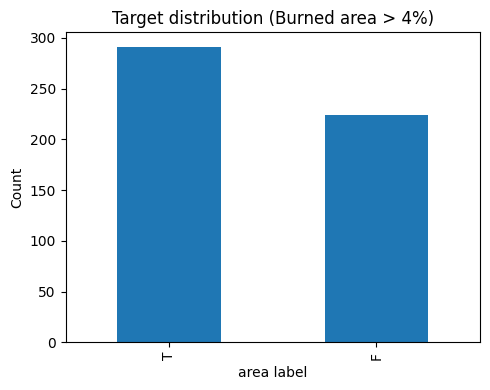

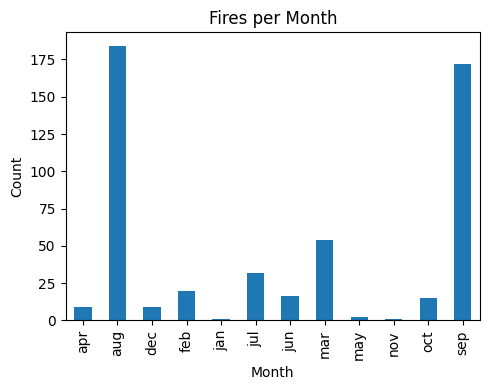

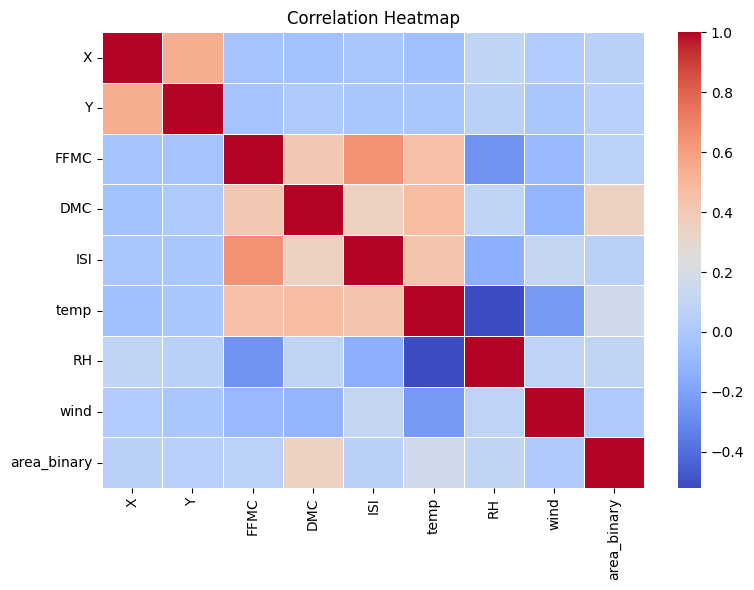

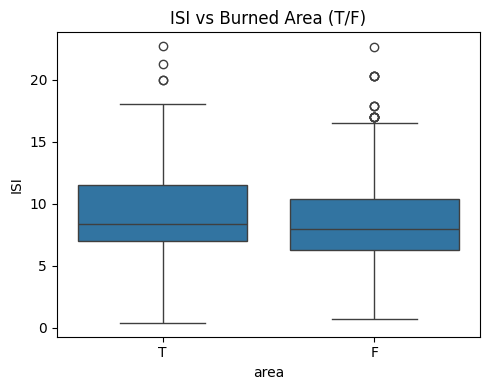

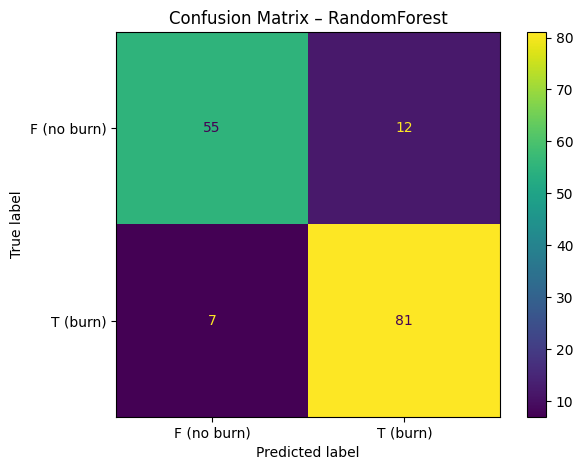

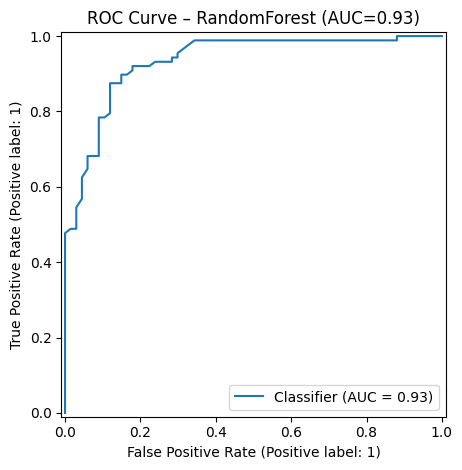

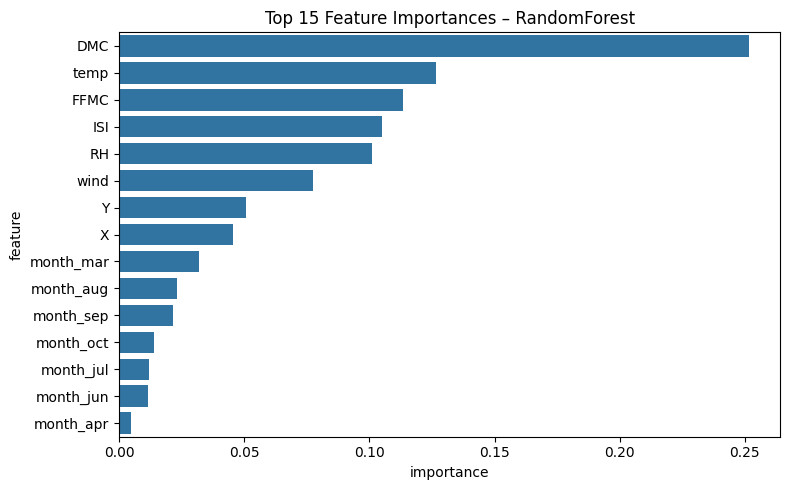

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score,
    RocCurveDisplay,
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

RANDOM_STATE = 42
DATA_PATH = "/content/forestfires_classification.csv"


# 1. DATA UNDERSTANDING

df = pd.read_csv(DATA_PATH)

print("First rows:")
print(df.head())
print("\nInfo:")
print(df.info())
print("\nDescribe numeric columns:")
print(df.describe())

print("\nTarget distribution (area):")
print(df["area"].value_counts())

print("\nMonth distribution:")
print(df["month"].value_counts())

print("\nDay distribution:")
print(df["day"].value_counts())

# Example quick plots for the poster
plt.figure(figsize=(5, 4))
df["area"].value_counts().plot(kind="bar")
plt.title("Target distribution (Burned area > 4%)")
plt.xlabel("area label")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("plot_target_distribution.png", dpi=300)

plt.figure(figsize=(5, 4))
df["month"].value_counts().sort_index().plot(kind="bar")
plt.title("Fires per Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("plot_month_distribution.png", dpi=300)


# 2. DATA PREPARATION & VISUALISATION

# Encode target as 0/1
df["area_binary"] = df["area"].map({"F": 0, "T": 1})

# Identify features & types
feature_cols = [
    "X", "Y", "month", "FFMC", "DMC", "ISI",
    "temp", "RH", "wind"
]

X = df[feature_cols]
y = df["area_binary"]

numeric_features = ["X", "Y", "FFMC", "DMC", "ISI", "temp", "RH", "wind"]
categorical_features = ["month"]

# Visualisation: correlation heatmap for numeric
plt.figure(figsize=(8, 6))
corr = df[numeric_features + ["area_binary"]].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("plot_correlation_heatmap.png", dpi=300)

# Example boxplot for one key feature
plt.figure(figsize=(5, 4))
sns.boxplot(x="area", y="ISI", data=df)
plt.title("ISI vs Burned Area (T/F)")
plt.tight_layout()
plt.savefig("plot_boxplot_isi_area.png", dpi=300)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=RANDOM_STATE,
)

print("\nTrain shape:", X_train.shape)
print("Test shape:", X_test.shape)

# 3. MODELLING APPROACH – PIPELINES DEFINITION

# Preprocessor: OneHot for categorical, StandardScaler for numeric
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Base models (no tuning yet)
base_models = {
    "LogReg": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "SVM": SVC(probability=True, random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(),
}

# 4. MODEL EXPERIMENTS & HYPERPARAMETER TUNING

cv_results = []

for name, clf in base_models.items():
    model = Pipeline(
        steps=[("preprocess", preprocess), ("clf", clf)]
    )
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="f1")
    cv_results.append(
        {
            "model": name,
            "mean_f1": scores.mean(),
            "std_f1": scores.std(),
        }
    )
    print(f"{name} CV F1: {scores.mean():.3f} ± {scores.std():.3f}")

cv_df = pd.DataFrame(cv_results).sort_values("mean_f1", ascending=False)
print("\nCross-validated F1 scores:\n", cv_df)

cv_df.to_csv("cv_results_base_models.csv", index=False)

# ---- Hyperparameter grids for top models (example) ----
param_grids = {
    "RandomForest": {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [None, 5, 10],
        "clf__min_samples_split": [2, 5],
    },
    "GradientBoosting": {
        "clf__n_estimators": [100, 200],
        "clf__learning_rate": [0.05, 0.1],
        "clf__max_depth": [3, 5],
    },
    "DecisionTree": {
        "clf__max_depth": [None, 5, 10, 20],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 4]
    },
}

best_models = {}

for name in ["RandomForest", "GradientBoosting", "DecisionTree"]:
    print(f"\nGrid search for {name}...")
    pipe = Pipeline(
        steps=[("preprocess", preprocess), ("clf", base_models[name])]
    )
    grid = GridSearchCV(
        pipe,
        param_grid=param_grids[name],
        cv=5,
        scoring="f1",
        n_jobs=-1,
    )
    grid.fit(X_train, y_train)
    print(f"Best F1 for {name}: {grid.best_score_:.3f}")
    print("Best params:", grid.best_params_)
    best_models[name] = grid

# Pick the single best model based on CV F1
best_name, best_grid = sorted(
    best_models.items(), key=lambda kv: kv[1].best_score_, reverse=True
)[0]

print(f"\nSelected final model: {best_name}")
final_model = best_grid.best_estimator_

# 5. FINAL MODEL – TEST SET EVALUATION & CONFUSION MATRIX

# Fit on full training data (already fitted by GridSearchCV, but we can refit explicitly)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

print("\nClassification report on TEST:")
print(classification_report(y_test, y_pred))

test_auc = roc_auc_score(y_test, y_proba)
print(f"Test ROC-AUC: {test_auc:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["F (no burn)", "T (burn)"])
disp.plot(values_format="d")
plt.title(f"Confusion Matrix – {best_name}")
plt.tight_layout()
plt.savefig("plot_confusion_matrix.png", dpi=300)

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title(f"ROC Curve – {best_name} (AUC={test_auc:.2f})")
plt.tight_layout()
plt.savefig("plot_roc_curve.png", dpi=300)

# 6. INSIGHTS – FEATURE IMPORTANCE / INTERPRETATION

# For tree-based models, we can inspect feature importances
if best_name in ["RandomForest", "GradientBoosting"]:
    # Get feature names after preprocessing
    ohe = final_model.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
    cat_feature_names = list(ohe.get_feature_names_out(categorical_features))
    all_feature_names = numeric_features + cat_feature_names

    # Extract importances from the tree-based classifier
    tree_clf = final_model.named_steps["clf"]
    importances = tree_clf.feature_importances_

    feat_imp = pd.DataFrame(
        {"feature": all_feature_names, "importance": importances}
    ).sort_values("importance", ascending=False)

    print("\nTop 15 important features:")
    print(feat_imp.head(15))

    # Bar plot of top features
    top_n = 15
    plt.figure(figsize=(8, 5))
    sns.barplot(
        x="importance",
        y="feature",
        data=feat_imp.head(top_n),
        orient="h"
    )
    plt.title(f"Top {top_n} Feature Importances – {best_name}")
    plt.tight_layout()
    plt.savefig("plot_feature_importances.png", dpi=300)

    feat_imp.to_csv("feature_importances.csv", index=False)

else:
    print(
        f"\nFinal model {best_name} does not have built-in feature_importances_. "
        "Consider permutation importance or switching to a tree-based model "
        "for interpretability."
    )